In [24]:
#Importación de librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold

from sklearn.preprocessing import Imputer

## Análisis exploratorio de datos 

In [23]:
df_bank = pd.read_csv('bank-full.csv', delimiter=';')
print("Dimensión data set",df_bank.shape)
df_bank



Dimensión data set (45211, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
5,35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no
6,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown,no
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,-1,0,unknown,no
8,58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,-1,0,unknown,no
9,43,technician,single,secondary,no,593,yes,no,unknown,5,may,55,1,-1,0,unknown,no


In [8]:
y = df_bank["y"]
y = y.replace("no", 0)
y = y.replace("yes", 1)
X = df_bank.drop('y', axis=1)


(45211, 16)


## Carácteristicas categóricas

En este caso se debe preprocesar aquellas carácteristicas categorical que el modelo no puede entender y convertirlas a variables númericas, a esto se le conoce como *"One Hot Encode"*. Se resuelve con la librería de sklearn o con pandas creando las variables ficticias conocidas **"Dummy variables"**.

Se debe tener en cuenta que podemos eliminar uno variable "dummy" porque si el resto de variables no son debe ser esa, esto quitará redundancia.

Este caso corresponde a las carácteristicas job,education,contact,month

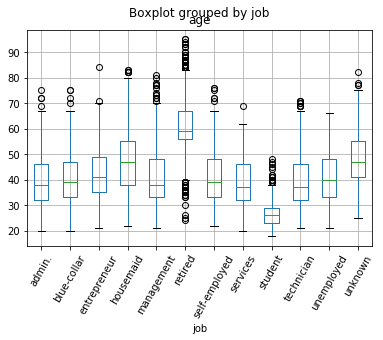

In [16]:
df_bank.boxplot('age','job',rot=60)
plt.show() 

In [19]:
df_job = pd.get_dummies(df_bank, 'job',drop_first=True)
df_job.head()

,age,balance,day,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,...,job_jun,job_mar,job_may,job_nov,job_oct,job_sep,job_other,job_success,job_unknown,job_yes
0,58,2143,5,261,1,-1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,44,29,5,151,1,-1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2,33,2,5,76,1,-1,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0
3,47,1506,5,92,1,-1,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
4,33,1,5,198,1,-1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


## Missing data

En nuestro análisis exploratorio, debemos lidiar con los valores faltantes. Al parecer en nuestro caso no hay, sin embargo muchas veces esos valores pueden de diferente formas tales como 0, signos de interrogación o números negativos (según su interpretación). Es así que decidimos ir más allá.

In [22]:
df_bank.info()
df_bank.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age          45211 non-null int64
job          45211 non-null object
marital      45211 non-null object
education    45211 non-null object
default      45211 non-null object
balance      45211 non-null int64
housing      45211 non-null object
loan         45211 non-null object
contact      45211 non-null object
day          45211 non-null int64
month        45211 non-null object
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null object
y            45211 non-null object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

# ---- REVISAR PREVIUOS -1

## Entrenamiento

In [10]:
def trainModel():
    random.seed(19680801)
    EficienciaTrain = np.zeros(Folds)
    EficienciaVal = np.zeros(Folds)
    skf = StratifiedKFold(n_splits=Folds)
    j = 0
    
    for train, test in skf.split(X, Y):
        Xtrain = X[train,:]
        Ytrain = Y[train]
        Xtest = X[test,:]
        Ytest = Y[test]

        #Normalizamos los datos
        media = np.mean(Xtrain)
        desvia = np.std(Xtrain)
        Xtrain = sc.stats.stats.zscore(Xtrain)
        Xtest = (Xtest - np.matlib.repmat(media, Xtest.shape[0], 1))/np.matlib.repmat(desvia, Xtest.shape[0], 1)

### Tener en cuenta

In [63]:
df_bank['job'].describe()

count           4521
unique            12
top       management
freq             969
Name: job, dtype: object

In [73]:
df_bank[df_bank['pdays'] == -1].shape

(36954, 17)

In [ ]:
out = df_bank["y"]
out = out.replace("no", 0)
out = out.replace("yes", 1)
x = df_bank["education"]
y = df_bank["job"]

#_ = sns.swarmplot(x='duration', y='age', data=df_bank)
#plt.hist(y)
# Label the axes
plt.title('Age vs housing', fontsize=14)
plt.xlabel('Edad')
plt.ylabel('duration')
plt.scatter(x,y,c=out,cmap="Accent")
plt.show()

In [ ]:
sns.set(style="whitegrid")
ax = sns.swarmplot(x="housing", y="age", data=df_bank)

In [34]:

#print("Tipos datos", df_bank.dtypes)
df_bank[df_bank['poutcome'] != 'unknown']
df_success = df_bank[df_bank['y'] == 'yes']
df_no_success = df_bank[df_bank['y'] == 'no']

print("Muestras de exito ",df_success.shape, "Muestras de no éxito",df_no_success.shape)

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64